# 1. Required dependencies: 

Outside of standard libraries in Python 3.7.0, the following libraries are required:

* Qiskit 0.20.0
* NumPy
* pylatexenc
* seaborn

In [ ]:
pip install qiskit -q

In [ ]:
pip install pylatexenc -q

In [ ]:
pip install seaborn -q

In [1]:
from qiskit import *
import matplotlib
import numpy as np

from qiskit.quantum_info import Statevector, random_statevector
from qiskit.visualization import plot_histogram, plot_state_qsphere
from qiskit.providers.aer import QasmSimulator
from qiskit.aqua.components.optimizers import AQGD

%matplotlib inline

# 2. Target output

The desired output of the optimized circuit is an equal probability of the computational basis measurements 01 and 10, or the statevector $|\Psi^+\rangle = \frac{|01\rangle + |10\rangle}{\sqrt{2}}$ prior to measurement. This state is the inverse of the more famous Bell state $|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$, which is typically formed by a Hadamard and CNOT gate.



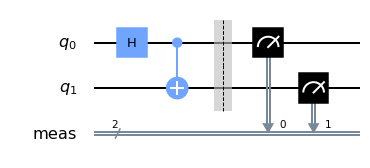

In [2]:
# Initialize Bell state circuit

circ_phi_plus = QuantumCircuit(2)
circ_phi_plus.h(0)
circ_phi_plus.cx(0,1)
circ_phi_plus.measure_all()

circ_phi_plus.draw(output='mpl')

The state $|\Psi^+\rangle$ can be achieved by placing an X gate on the target qubit ahead of the CNOT, as shown in the circuit below.

Note that this information is provided for purposes of logic comparison only. The high-level circuit used to achieve $|\Psi^+\rangle$ assumes an initial state of $|00\rangle$, and thus is trivial in cases where the inital state is random.

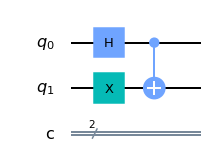

In [3]:
# Initialize Bell state circuit for statevector observation

circ_psi_plus = QuantumCircuit(2,2)
circ_psi_plus.x(1)
circ_psi_plus.h(0)
circ_psi_plus.cx(0,1)

circ_psi_plus.draw(output='mpl')

Statevector:  [0.        +0.j 0.70710678+0.j 0.70710678+0.j 0.        +0.j] 



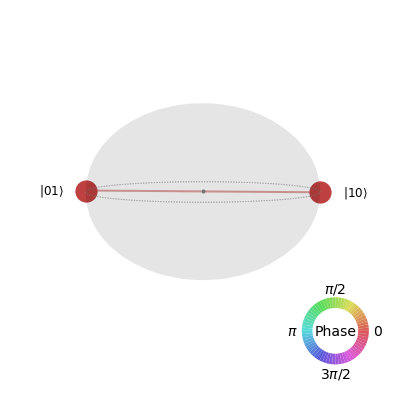

In [4]:
# Statevector output of Bell state circuit

backend_state = Aer.get_backend('statevector_simulator')
result = execute(circ_psi_plus,backend_state).result().get_statevector()
print("Statevector: ", result, "\n")

state = Statevector.from_instruction(circ_psi_plus)
plot_state_qsphere(state)

{'10': 1} 

{'01': 9, '10': 1} 

{'01': 58, '10': 42} 

{'01': 496, '10': 504} 



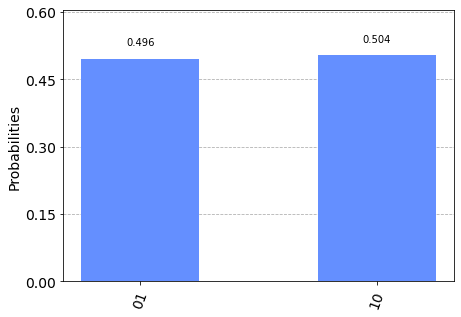

In [5]:
# Prepare simulation on qasm_simulator backend

# Add measurements to end of circuit
circ_psi_plus.measure([0,1],[0,1])

# Initialize measurement arrays
num_meas = [1, 10, 100, 1000]
counts_psi_plus = [0,0,0,0]

# Select qasm_simulator backend, a noisy quantum circuit simulator when used with density matrix method
backend_meas = Aer.get_backend('qasm_simulator')
backend_options = {"method": "density_matrix"}

# Number of measurements varied on each execution
for i in range(4):
  job_meas = execute(circ_psi_plus, backend_meas, shots = num_meas[i], backend_properties=backend_options)
  result_meas  = job_meas.result()
  counts_psi_plus[i] = result_meas.get_counts()
  print(counts_psi_plus[i], "\n")

plot_histogram(counts_psi_plus[3])
#subplot??

# 3. Circuit Optimization with Known Initial State

In the code blocks below, the circuit architecture to be optimized is drawn, setting all initial rotation angles to 0. Note that because the circuit is built and simulated in Qiskit, a default inital state of $|00\rangle$  is assumed when not specified otherwise.

The purpose of examining the output in this situation is to validate the optimization algorithm and demonstrate that the architecture is acceptable for reaching the entangled state. 


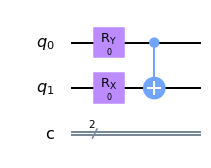

In [6]:
# Initialize gate parameters at 0

theta_x_1 = 0.0
theta_y_0 = 0.0

# Initialize circuit for optimization, allowing default state |00>

circ = QuantumCircuit(2,2)

circ.ry(theta_y_0, 0)
circ.rx(theta_x_1, 1)
circ.cx(0,1)

circ.draw(output='mpl')

This circuit is constructed to create an entanglement such that the computational basis measurements 01 and 10 are at equal probabilities. An X rotation gate is provided on the target qubit ``` q_1 ``` in order to provide the required qubit flip to $|1\rangle$ once optimized. Additionally, a Y rotation gate on ``` q_0 ``` will be used to form the desired superposition.

Initial Statevector:  [1.+0.j 0.+0.j 0.+0.j 0.+0.j] 



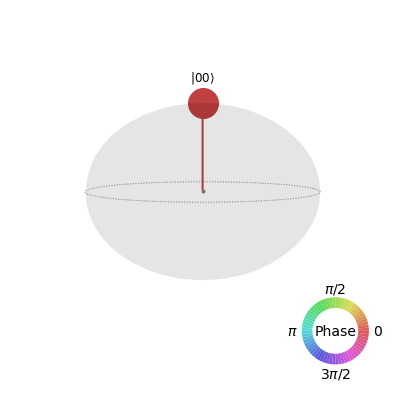

In [7]:
# Initial statevector output of unoptimized circuit
backend_state = Aer.get_backend('statevector_simulator')
result = execute(circ,backend_state).result().get_statevector()
print("Initial Statevector: ", result, "\n")

state = Statevector.from_instruction(circ)
plot_state_qsphere(state)

In order to expedite this optimization, the Analytic Quantum Gradient Descent (AQGD) optimizer will be used for each gate parameter. AQGD is a local optimization method created specifically for parameterized gate minimizations given an objective output. \[[1](https://qiskit.org/documentation/stubs/qiskit.aqua.components.optimizers.AQGD.html),[2](https://link.aps.org/accepted/10.1103/PhysRevA.98.032309)\]

The cells below set up the optimization function to be executed throughout this project. The target function is set to require an output of 01 and 10, each at an amplitude of 0.5. For purposes of expediting the optimization, the tolerance and maximum iterations are set to $1\times 10^{-5}$ and 500, respectively. The learning rate $\eta$ and the gradient momentum bias are left at their default values.

In [ ]:
def obj_fun():
    

In [ ]:
def grad_fun():
    

In [ ]:
aqgd = AQGD(maxiter = 500, eta = 2.0, tol = 1e-06, disp = False, momentum = 0.25)
angles = np.array([[theta_y_0],[theta_x_1]])

# Conduct optimization of gate angles
aqgd.optimize(2, obj_fun(), gradient_function = grad_fun(), variable_bounds = (0, 2*np.pi), initial_point = [0, 0]) 

In [ ]:
# Reprint optimized circuit with default state |00>

circ = QuantumCircuit(2,2)

circ.ry(theta_y_0, 0)
circ.rx(theta_x_1, 1)
circ.cx(0,1)

circ.draw(output='mpl')

In [ ]:
# Statevector output after circuit optimization
backend_state = Aer.get_backend('statevector_simulator')
result = execute(circ,backend_state).result().get_statevector()
print("Optimized Statevector: ", result, "\n")

state = Statevector.from_instruction(circ)
plot_state_qsphere(state)

In [ ]:
# Prepare simulation on qasm_simulator backend

# Add measurements to optimized circuit
circ.measure([0,1],[0,1])

# Reset counts matrix
counts_meas = [0,0,0,0]

# Again, use qasm_simulator backend with density_matrix method
backend_meas = Aer.get_backend('qasm_simulator')
backend_options = {"method": "density_matrix"}

for i in range(4):
  job_meas = execute(circ, backend_meas, shots = num_meas[i], backend_properties=backend_options)
  result_meas  = job_meas.result()
  counts_meas[i] = result_meas.get_counts()
  print(counts_meas[i], "\n")

plot_histogram(counts_meas[3])
#subplot??


# 4. Circuit Optimization with Random Initial State



Now, the previously written AQGD method is used to optimize a randomly initialized quantum circuit based on a randomly generated statevector.

In [ ]:
# Initialize gate parameters at 0
theta_x_1 = 0.0
theta_y_0 = 0.0

# Create random quantum state
rand_state = random_statevector(4)
print('initial state: {}' .format(rand_state))

# Initialize circuit for optimization with random initial state
q = QuantumRegister(2)
c = ClassicalRegister(2)
circ2 = QuantumCircuit(q,c)
circ2.initialize(rand_state.data,[q[0],q[1]])

circ2.ry(theta_y_0, 0)
circ2.rx(theta_x_1, 1)
circ2.cx(0,1)

circ2.draw(output='mpl')

In [ ]:
# Statevector output after circuit optimization
backend_state = Aer.get_backend('statevector_simulator')
result = execute(circ2,backend_state).result().get_statevector()
print("Initial Statevector: ", result, "\n")

state = Statevector.from_instruction(circ2)
plot_state_qsphere(state)

In [ ]:
# AQGD placeholder
aqgd2 = AQGD(maxiter = 500, eta = 2.0, tol = 1e-06, disp = False, momentum = 0.25)
angles2 = np.array([[theta_y_0],[theta_x_1]])

# Conduct optimization of gate angles
aqgd2.optimize(2, obj_fun(), gradient_function = grad_fun(), initial_point = [0, 0]) 

In [ ]:
# Redraw optimized circuit with random initial state??

circ2 = QuantumCircuit(2,2)

circ2.ry(theta_y_0, 0)
circ2.rx(theta_x_1, 1)
circ2.cx(0,1)

circ2.draw(output='mpl')

In [ ]:
# Statevector output after circuit optimization
backend_state = Aer.get_backend('statevector_simulator')
result = execute(circ2,backend_state).result().get_statevector()
print("Optimized Statevector: ", result, "\n")

state = Statevector.from_instruction(circ2)
plot_state_qsphere(state)

In [ ]:
# Prepare simulation on qasm_simulator backend - vary by number of measurements

circ2.measure([0,1],[0,1])

counts_meas = [0,0,0,0]

# Again, use qasm_simulator backend with density_matrix method
backend_meas = Aer.get_backend('qasm_simulator')
backend_options = {"method": "density_matrix"}

for i in range(4):
  job_meas = execute(circ2, backend_meas, shots = num_meas[i], backend_properties=backend_options)
  result_meas  = job_meas.result()
  counts_meas[i] = result_meas.get_counts()
  print(counts_meas[i], "\n")

plot_histogram(counts_meas[3])
#subplot??


# 5. Global Phase Factor Regulation

In this project, the target output statevector assumed a phase of 0 on both qubits. Maintaining this phase angle on each qubit is achieved by forcing all four amplitudes in the statevector to be real, and thus is handled by the gate parameter optimization.

In general, a global phase factor of zero can be maintained by applying some RZ rotation such that it is returned to 0. The phase angle of this gate $\theta$ can be optimized by a similar AQGD process like the one above. When the RZ gate is not available in the transpiled circuit, the equivalent gate can be achieved from an equivalent series of RX and RY gates:

$$
R_Z(\theta) = e^{-i\theta/2Z}
= e^{-i\theta/2(-iXY)}
= e^{-i\theta/4X}e^{-i\theta/4Y}
= R_X(\theta/2)R_Y(\theta/2)
$$

By this decomposition, an RZ operation can be created by an RXRY operation at half the required phase rotation.